In [22]:
import os
import sys
import time
import json
import random
import groq
from huggingface_hub import HfFolder, Repository, create_repo, whoami
from huggingface_hub.utils import logging as hf_logging
from dotenv import load_dotenv
import os
import re
import math
from tqdm import tqdm
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, set_seed, BitsAndBytesConfig
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
import pickle
from testing import Tester
import os

In [16]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [17]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [18]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [19]:
client = groq.Client(
    api_key=os.environ.get("GROQ_API_KEY"),
)


In [20]:
def groq_llama_mini(item):
    try:
        response = client.chat.completions.create(
            model="llama3-70b-8192",
            messages=messages_for(item),
            max_tokens=5,
            temperature=0.0,
            seed=42
        )
        reply = response.choices[0].message.content.strip()
        return get_price(reply)
    except Exception as e:
        print(f"Groq API Error: {e}")
        return None

1: Guess: $24.99 Truth: $42.29 Error: $17.30 SLE: 0.26 Item: Igloo 110V AC Power Converter for Iceles...
2: Guess: $130.00 Truth: $176.99 Error: $46.99 SLE: 0.09 Item: Soundstream PN4.1000D 1000W 4-Channel Pi...
3: Guess: $25.99 Truth: $52.98 Error: $26.99 SLE: 0.48 Item: Batterymarket New BTY-L76 Replacement La...
4: Guess: $169.99 Truth: $178.99 Error: $9.00 SLE: 0.00 Item: IYING 7 Inch Car Radio Wireless CarPlay ...
5: Guess: $25.00 Truth: $52.99 Error: $27.99 SLE: 0.53 Item: AmScope EP10X30ER Extreme Widefield 10X/...
6: Guess: $69.99 Truth: $36.98 Error: $33.01 SLE: 0.39 Item: 2023 WiFi Extender - Wireless Signal Rep...
7: Guess: $6.99 Truth: $4.99 Error: $2.00 SLE: 0.08 Item: Honda CRX 2nd Gen Outline Car Window Sti...
8: Guess: $250.00 Truth: $94.99 Error: $155.01 SLE: 0.92 Item: Honeywell VISTA-20P Ademco Control Panel...
9: Guess: $129.99 Truth: $598.86 Error: $468.87 SLE: 2.32 Item: ASUS GTX950 2G GDDR5 PCI Express 3.0 HDC...
10: Guess: $8.99 Truth: $12.99 Error: $4.00 SLE: 0

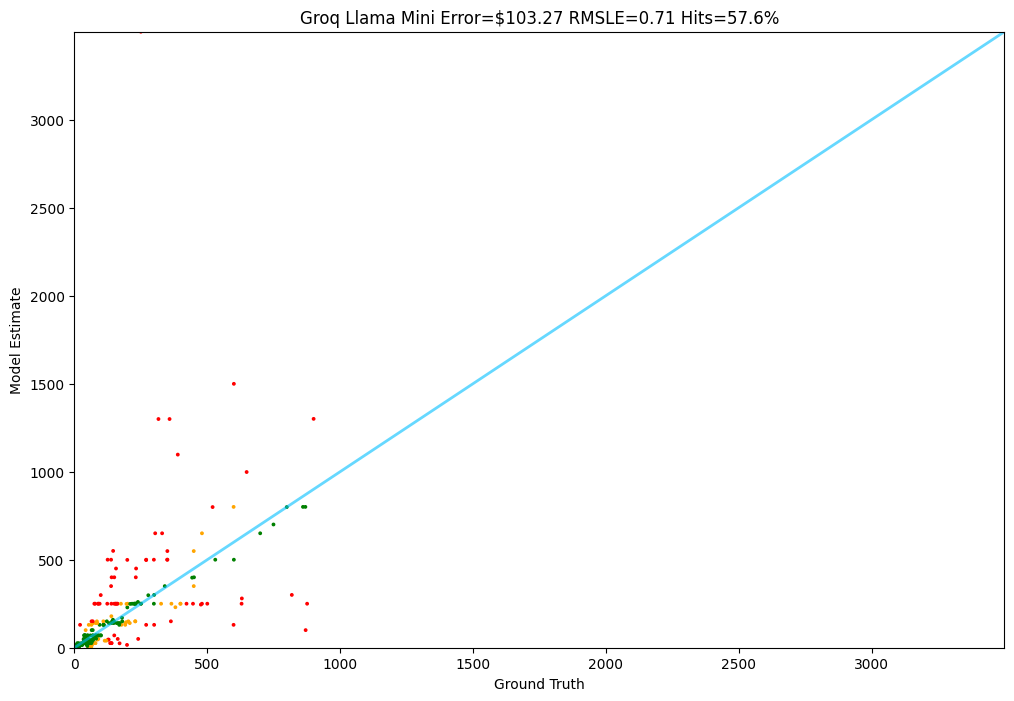

In [25]:
Tester.test(groq_llama_mini, test)